# Прогнозирование оттока клиентов сети фитнес-центров <br> «Культурист-датасаентист»

Задача — провести анализ и подготовить план действий по удержанию клиентов, а именно:
- спрогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
- сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
- проанализировать основные признаки, наиболее сильно влияющие на отток;
- сделать выводы и разработать рекомендации по повышению качества работы с клиентами:
    * выделить целевые группы клиентов;
    * предложить меры по снижению оттока;
    * определить другие особенности взаимодействия с клиентами.

## Описание данных

«Культурист-датасаентист» предоставил сведения в csv-файлах, которые содержат данные на месяц до оттока и факт оттока на определённый месяц. Набор данных включает следующие поля:
<br><br>
Данные клиента за предыдущий до проверки факта оттока месяц:
- 'gender' — пол;
- 'Near_Location' — проживание или работа в районе, где находится фитнес-центр;
- 'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
- 'Promo_friends' — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
- 'Phone' — наличие контактного телефона;
- 'Age' — возраст;
- 'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах).
<br><br>

Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:

- 'Contract_period' — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год);
- 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах);
- 'Group_visits' — факт посещения групповых занятий;
- 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента;
- 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц;
- 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон;
<br><br>

Специальное поле:

- 'Churn' — факт оттока в текущем месяце.

## Загрузка данных и их подготовка

Импорт библиотек и методов. Установка основных настроек.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore')

sns.set_palette('Set2')
pd.options.display.float_format = '{:,.2f}'.format

Сохранение данных в переменную. Просмотр информации о датафрейме и вывод на экран нескольких строк из таблицы для ознакомления с данными.

In [2]:
gym = pd.read_csv('/datasets/gym_churn.csv')
gym.info()
gym.sample(n=10, random_state=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
Near_Location                        4000 non-null int64
Partner                              4000 non-null int64
Promo_friends                        4000 non-null int64
Phone                                4000 non-null int64
Contract_period                      4000 non-null int64
Group_visits                         4000 non-null int64
Age                                  4000 non-null int64
Avg_additional_charges_total         4000 non-null float64
Month_to_end_contract                4000 non-null float64
Lifetime                             4000 non-null int64
Avg_class_frequency_total            4000 non-null float64
Avg_class_frequency_current_month    4000 non-null float64
Churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
200,0,1,1,0,1,1,0,34,46.49,1.00,0,1.01,0.00,1
1078,1,1,0,0,1,1,0,27,24.55,1.00,4,1.39,0.98,1
610,1,1,1,1,1,6,1,31,85.67,6.00,1,1.01,0.73,1
2159,1,0,1,0,1,1,0,26,75.80,1.00,1,1.46,1.54,1
1169,0,0,0,0,1,1,0,31,410.76,1.00,3,2.40,2.47,0
2448,0,0,0,0,1,12,1,28,106.11,10.00,3,2.56,2.52,0
2938,1,1,0,0,0,1,0,23,199.16,1.00,0,2.95,2.70,1
813,1,1,1,1,1,6,1,34,115.87,4.00,9,0.65,0.57,0
1268,0,1,0,1,1,1,0,29,158.98,1.00,2,1.78,0.71,1
870,0,1,0,0,1,1,1,32,67.59,1.00,4,1.22,1.33,0


Видим, что столбец 'Month_to_end_contract' содержит целочисленные значения, а тип имеет вещественный. Поэтому преобразуем тип данных этого столбца.

In [3]:
gym['Month_to_end_contract'] = gym['Month_to_end_contract'].astype('int64')

Названия столбцов достаточно информативны, но для удобства дальнейшей работы их необходимо привести к нижнему регистру.

In [4]:
gym.columns = gym.columns.str.lower()
gym.columns

Index(['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'age',
       'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
       'avg_class_frequency_total', 'avg_class_frequency_current_month',
       'churn'],
      dtype='object')

Проверка данных на дубликаты:

In [5]:
print('Количество дубликатов в датафрейме:', gym.duplicated().sum())

Количество дубликатов в датафрейме: 0


**Вывод**

Датасет имеет 4000 записей и 14 полей (13 признаков и 1 целевая переменная). Все признаки - числовые. Целевая переменная не имеет временной структуры. Также из выведенной информации видно, что в таблице нет пропущенных значений. Типы данных всех столбцов соответствуют содержащейся в них информации, либо преобразованы на соответствующий. Названия столбцов приведены к нижнему регистру. Проведена проверка на наличие дубликатов - дубликаты обнаружены не были. Таким образом, мы ознакомились с данными и подготовили датафрейм для дальнейшей работы.

## Исследовательский анализ данных (EDA)

Посмотрим числовое описание всех столбцов:

In [6]:
gym.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,"4,000.00",0.51,0.50,0.00,0.00,1.00,1.00,1.00
near_location,"4,000.00",0.85,0.36,0.00,1.00,1.00,1.00,1.00
partner,"4,000.00",0.49,0.50,0.00,0.00,0.00,1.00,1.00
promo_friends,"4,000.00",0.31,0.46,0.00,0.00,0.00,1.00,1.00
phone,"4,000.00",0.90,0.30,0.00,1.00,1.00,1.00,1.00
contract_period,"4,000.00",4.68,4.55,1.00,1.00,1.00,6.00,12.00
group_visits,"4,000.00",0.41,0.49,0.00,0.00,0.00,1.00,1.00
age,"4,000.00",29.18,3.26,18.00,27.00,29.00,31.00,41.00
avg_additional_charges_total,"4,000.00",146.94,96.36,0.15,68.87,136.22,210.95,552.59
month_to_end_contract,"4,000.00",4.32,4.19,1.00,1.00,1.00,6.00,12.00


Из числового описания можно извлечь следующую информацию:

- По среднему значению бинарного поля 'gender' видим, что среди клиентов примерно поровну лиц обоих полов;
- По первому квартилю и среднему значению столбца 'near_location' делаем вывод, что б**о**льшая часть клиентов имеет неподалёку от фитнес-центра работу или дом;
- Среднее значение поля 'partner' говорит о том, что чуть меньше половины клиентов являются сотрудниками компаниий-партнёров клуба;
- Числовое описание поля 'promo_friends' показывает, что около 30% клиентов пришли в фитнес-центр по акции "Приведи друга";
- Большинство клиентов оставили свой контактный телефон клубу;
- Половина абонементов оформлено на срок 1 месяц, около 25% абонементов имеют срок действия 6 или 12 месяцев;
- Групповые занятия гораздо менее популярны, чем свободное посещение;
- Средний и медианный возраст посетителей совпадает и составляет 29 лет;
- Средняя выручка от дополнительных услуг фитнес-клуба составляет 147 денежных единиц (д.е.), что лежит близко к медианному значению в 136 д.е., то есть выбросов в выборке немного, либо они имеют не столь большое значение;
- Значения числовых параметров столбца 'month_to_end_contract' очень похоже на 'contract_period'. Это и понятно, ведь по логике вещей эти два поля имеют заметную взаимосвязь;
- Половина клиентов имеют лайфтайм в 3 месяца, и лишь 25% посетителей занимаются в клубе более 5 месяцев. Среднее значение лайфтайма составляет 3,7 мес;
- Средняя частота посещений в неделю за все время с начала действия абонемента 'avg_class_frequency_total' для половины клиентов - немного меньше 2, а именно 1.88 раз в неделю;
- Средняя частота посещений в неделю за предыдущий месяц чуть меньше числового значения среднего для предыдущего столбца - 1.77 раз в неделю. В целом люди не склонны изменять своим привычкам;
- Около 26% клиентов показывают отток в текущем месяце.

Разделим выборку на две группы по признаку оттока и посмотрим на средние значения признаков в получившихся группах.

In [7]:
(gym
    .groupby(['churn'])
    .agg('mean')
    .reset_index()
    .T
)

,0,1
churn,0.00,1.00
gender,0.51,0.51
near_location,0.87,0.77
partner,0.53,0.36
promo_friends,0.35,0.18
phone,0.90,0.90
contract_period,5.75,1.73
group_visits,0.46,0.27
age,29.98,26.99
avg_additional_charges_total,158.45,115.08


Параметры, которые находятся на одном уровне в обоих группах, и их всего два - это пол gender, наличие телефона phone.

Значение показателя near_location в группе клиентов, показавших отток, немного ниже по сравнению с другой группой (0.77 против 0.87). Среди оттекших посетителей меньше сотрудников компаний-партнёров клуба. Интересная картина с параметром promo_friends - люди, которых пригласили друзья/знакомые по акции "Приведи друга", попадают в отток примерно в 2 раза реже, чем те, кто пришёл в спортзал без рекомендаций.

Средние значения поля contract_period сигнализируют о том, что люди, ушедшие впоследствие в отток, выбирают абонементы на более короткий срок, чем те, кто продолжают посещать фитнес-центр. Также бросившие спортзал клиенты реже посещают групповые занятия, а ещё они в среднем на три года моложе (26 и 29 лет соответственно). На дополнительные услуги (avg_additional_charges_total) "продолжающие" посетители тратят в среднем на 37% больше денег по сравнению с ушедшими.

Количество месяцев до окончания текущего абонемента в обеих группах также значительно отличается - аж в 3 раза (у показавших отток этот параметр меньше). Лайфтайм бросивших в 4,7 раза меньше. А средняя частота посещения в неделю общая ниже на 25% в группе с параметром churn, равным 1. Средняя же частота посещения в текущем месяце и вовсе отличается в 2 раза (и у оттёкших снова показатель ниже).

Построим распределения признаков для тех, кто ушёл (отток), и тех, кто остался (не попали в отток): для бинарных признаков - ввиде столбцатых диаграмм, для небинарных - ввиде гистограмм.

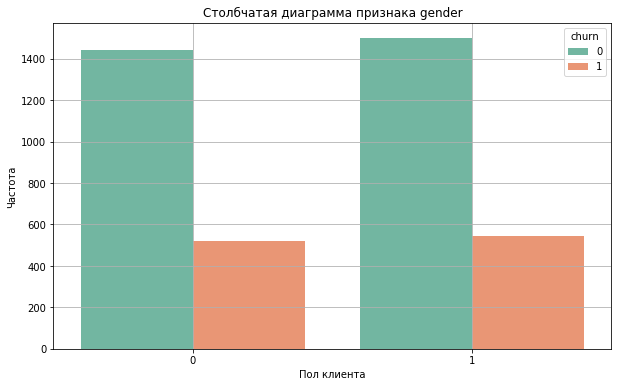

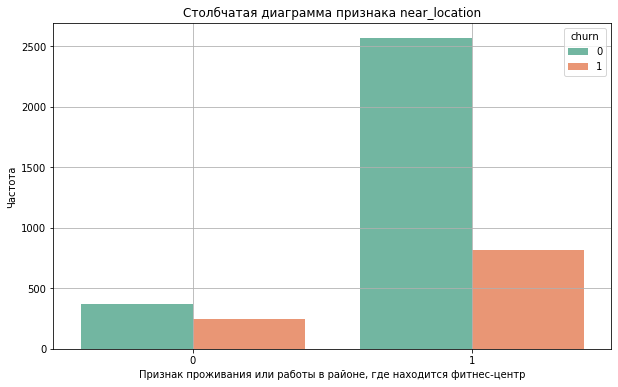

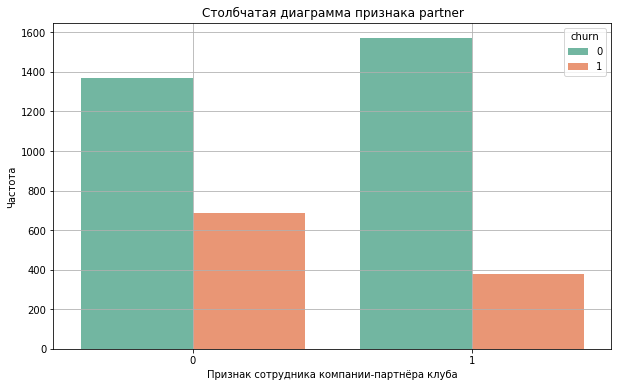

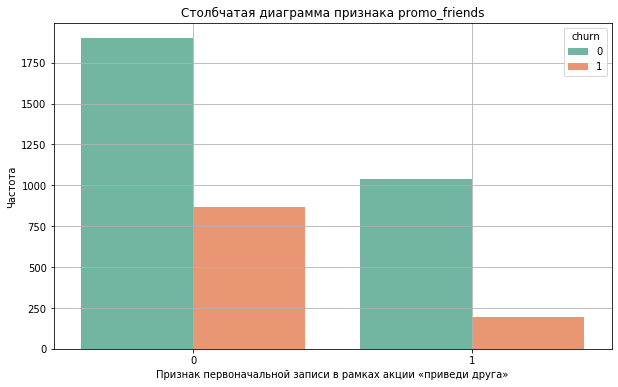

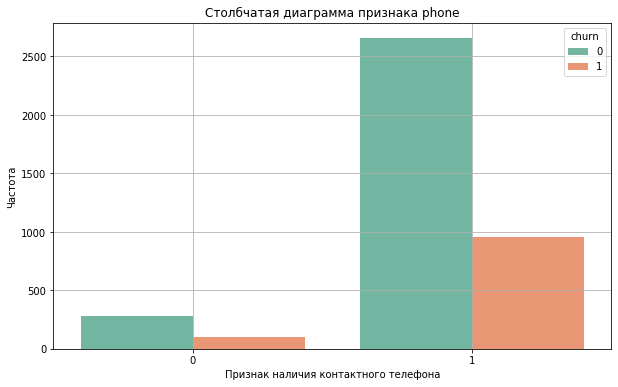

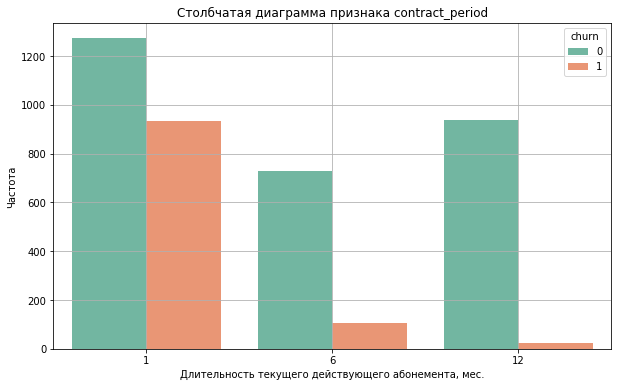

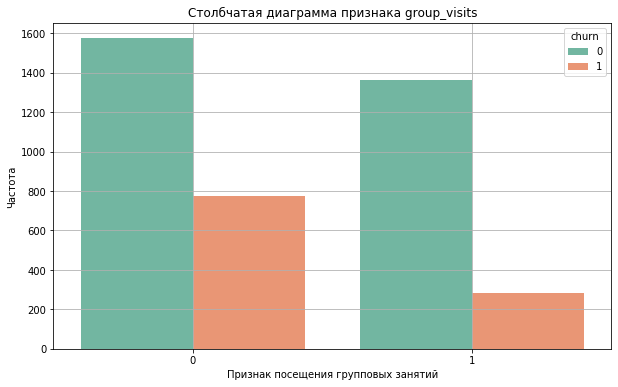

In [8]:
dict_of_features_bin = {'gender' : 'Пол клиента',
                        'near_location' : 'Признак проживания или работы в районе, где находится фитнес-центр', 
                        'partner' : 'Признак сотрудника компании-партнёра клуба',
                        'promo_friends' : 'Признак первоначальной записи в рамках акции «приведи друга»',
                        'phone': 'Признак наличия контактного телефона',
                        'contract_period': 'Длительность текущего действующего абонемента, мес.',
                        'group_visits': 'Признак посещения групповых занятий',
                        }

for feature in dict_of_features_bin.keys():
    plt.figure(figsize=(10, 6))
    sns.countplot(x = gym[feature], hue='churn', data=gym)
    plt.title('Столбчатая диаграмма признака ' + feature)
    plt.xlabel(dict_of_features_bin[feature])
    plt.ylabel('Частота')
    plt.grid()
    plt.show()

- Распределение полов в обеих группах примерно одинаково, то есть пол клиента по всей видимости никак не влияет на принятие решение ухода из спорт-клуба;
- Диаграмма признака near_location, показывает, что доля ушедших в категории клиентов, не проживающих или не работающих в районе, где находится фитнес-центр, больше. Это значит, что удалённость от фитнес-центра оказывает заметное влияние на отток;
- Из графика признака partner видно, что доля оттекших клиентов, не являющихся сотрудниками компаний-партнёров, больше. Другими словами, люди более лояльны к фитнес-центру, если они работают в компаниях, чьи сотрудники могут получать скидки на абонемент;
- Распределение признака promo_frends подтверждает выводы, сделанные ранее, а именно - люди, которых пригласили друзья/знакомые по акции "Приведи друга", попадают в отток значительно реже, чем те, кто пришёл в спортзал без рекомендаций;
- Из диаграммы признака phone видно, что желание оставить фитнес-клубу свой контактный номер телефона не оказывает заметного влияния на отток;
- График contract_period наглядно отражает тот факт, что среди клиентов, купивших абонемент на 1 месяц, самая высокая доля ушедших. А по мере возрастания длительности абонемента доля таких клиентов очень ощутимо снижается;
- Глядя на крайнее распределение можно сделать вывод, что люди, посещающие групповые занятия, менее склонны бросать занятия в спорт-клубе.

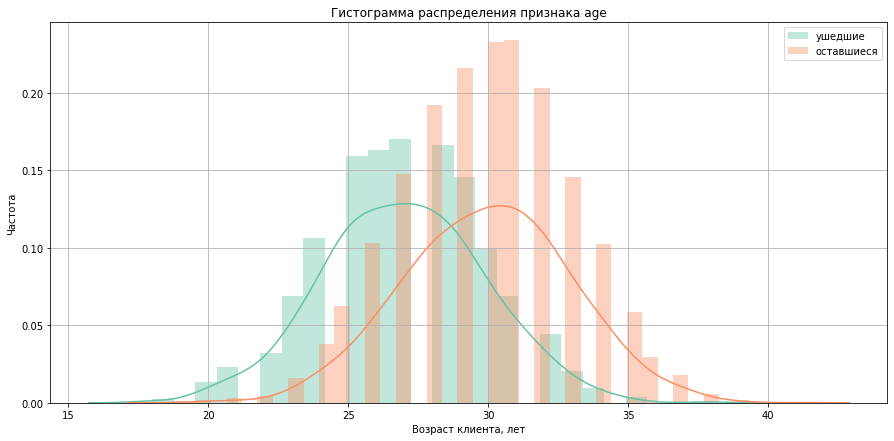

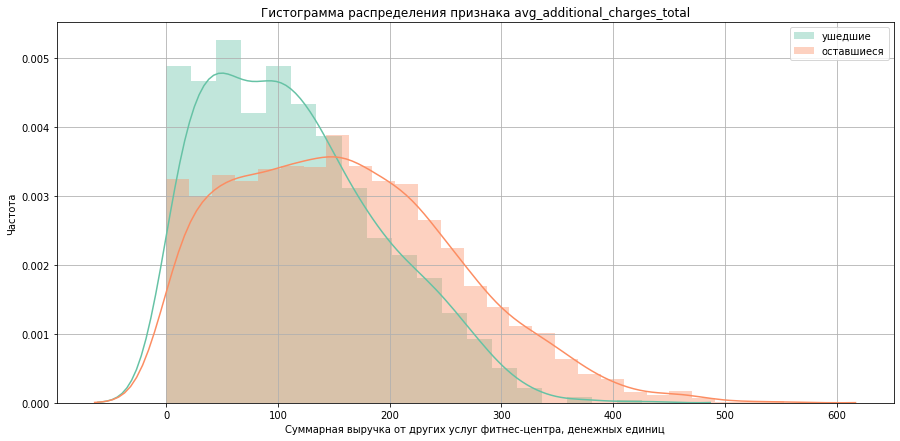

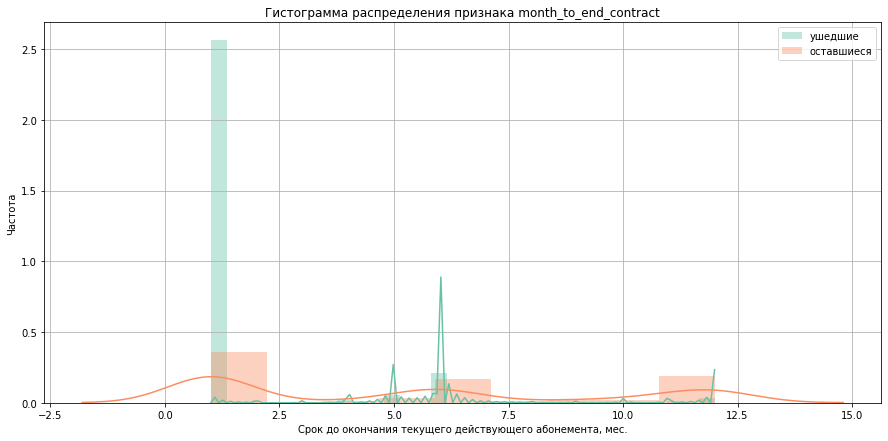

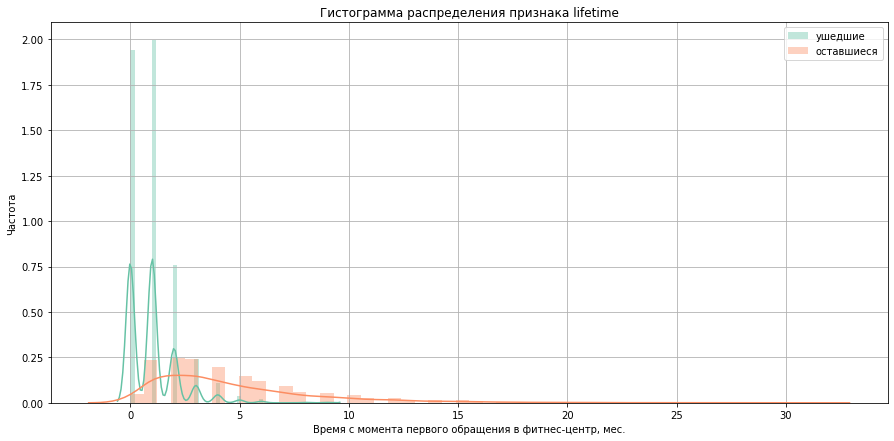

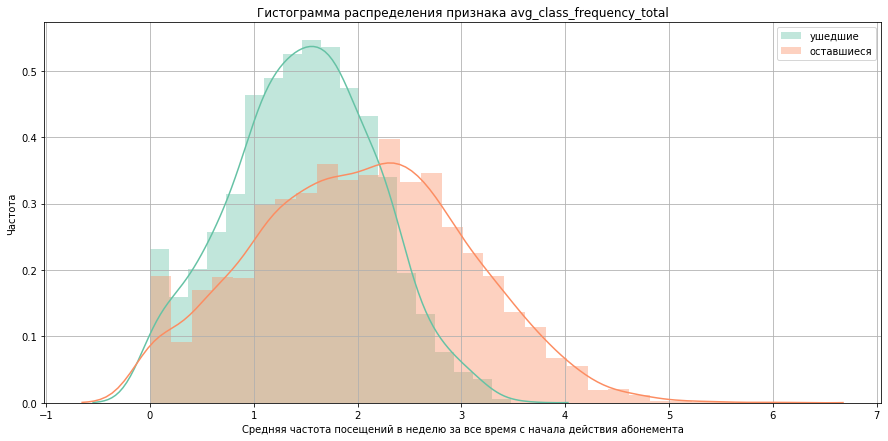

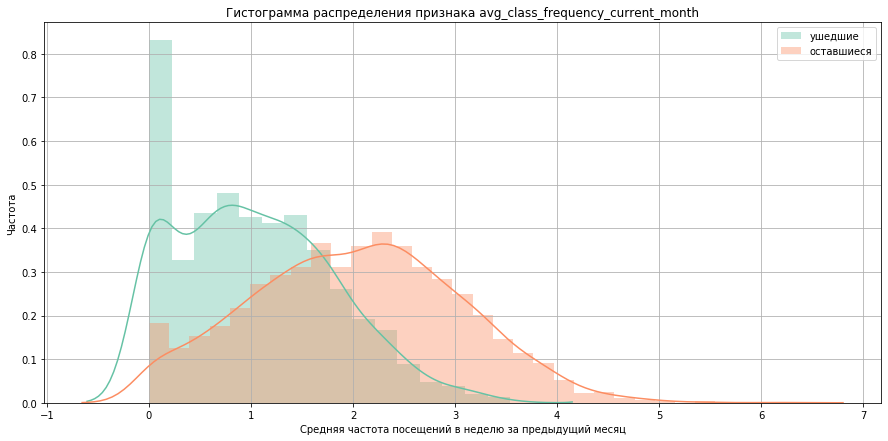

In [9]:
dict_of_features = {'age': 'Возраст клиента, лет',
                    'avg_additional_charges_total': 'Суммарная выручка от других услуг фитнес-центра, денежных единиц',
                    'month_to_end_contract': 'Срок до окончания текущего действующего абонемента, мес.',
                    'lifetime': 'Время с момента первого обращения в фитнес-центр, мес.',
                    'avg_class_frequency_total': 'Средняя частота посещений в неделю за все время с начала действия абонемента',
                    'avg_class_frequency_current_month': 'Средняя частота посещений в неделю за предыдущий месяц'
                   }

for feature in dict_of_features.keys():
    plt.figure(figsize=(15, 7))
    ax1 = sns.distplot(gym[gym['churn'] == 1][feature], label='ушедшие')
    ax2 = sns.distplot(gym[gym['churn'] == 0][feature], label='оставшиеся')
    ax1.set_title('Гистограмма распределения признака ' + feature)
    ax1.set_xlabel(dict_of_features[feature])
    ax1.set_ylabel('Частота')
    ax1.legend(loc = 'upper right')
    ax2.legend(loc = 'upper right')
    plt.grid()
    plt.show()

Гистограммы распределений показывают, что:
- клиенты, попадающие в отток, моложе оставшихся;
- ушедшие посетители чаще тратят меньшие суммы денег на другие услуги фитнес-центра, в то время как распределение трат оставшихся посетителей намного более плавное;
- Срок до окончания действующего абонемента у оттекших клиентов в подавляющем большинстве случаев - 1 месяц. Для продолжающих клиентов распределение снова плавное;
- Время с момента первого обращения в фитнес-центр (лайфтайм) у оттекших в большинстве своём намного короче, чем у оставшихся;
- ушедшие клиенты посещали клуб с меньшей частотой (в неделю), чем продолжающие. На гистограмме распределения средней частоты посещений в неделю за предыдущий месяц виден большой пик около нуля у клиентов, попавших в отток.

Построим матрицу корреляций и отобразим её ввиде тепловой карты:

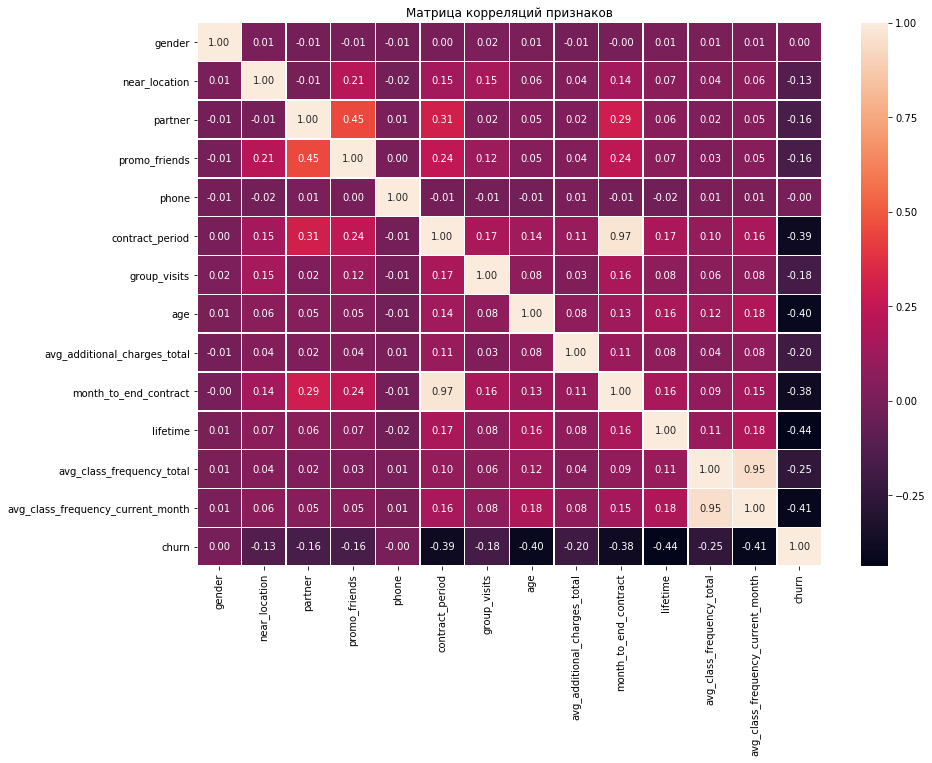

In [10]:
cm = gym.corr()
plt.figure(figsize=(14, 10))
sns.heatmap(cm, annot = True, fmt = '0.2f', linewidths=.5)
plt.title('Матрица корреляций признаков')
plt.show()

Наиболее сильная корреляция наблюдается между следующими признаками:
- 'contract_period' — длительность текущего действующего абонемента и 'month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах);
- 'avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента и 'avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц;

Вышеперечисленные признаки - мультиколлинеарные.
<br><br>
Признаки с нулевой корреляцией с целевой переменной churn: gender, phone.

**Вывод**

Проведя исследовательский анализ данных, мы пришли к следующим выводам:
- Гендерный признак age и признак наличия контактного телефона phone не оказывают влияния на целевую переменную churn;
- Признак near_location влияет на целевую переменную следующим образом - чем дальше человек живёт/работает от клуба, тем вероятнее он попадёт в отток;
- Анализ показателя partner показал, что клиенты, являющиеся сотрудниками компаний-парнтёров клуба, реже уходят;
- Если клиент пришёл в клуб в рамках акции «Приведи друга» (признак promo_friends), то он с б**о**льшей вероятностью будет продолжать занятия спортом;
- Большинство посетителей, попавших в отток, имеют абонемент длительностью 1 месяц - это видно из анализа параметра contract_period. Кроме того, признаки contract_period и month_to_end_contract мультиколлинеарны;
- Чем реже клиент посещает групповые занятия, тем чаще он попадает в отток (параметр group_visits);
- Отчётливо видна отрицательная корреляция между возрастом age и оттоком churn - чем старше человек, тем реже он оказывается в группе ушедших клиентов;
- Признак avg_additional_charges_total влияет на churn так - чем меньшая сумма денег тратится на другие услуги фитнес-центра, тем чаще клиент оттекает;
- Признак lifetime у ушедших посетителей меньше, чем у оставшихся;
- Признаки avg_class_frequency_total и avg_class_frequency_current_month мультиколлинеарны, они почти одинаково воздействуют на отток - чем реже клиент посещает спорт-зал, тем чаще бросает.

## Построение модели прогнозирования оттока клиентов

Построим модель бинарной классификации клиентов, где целевой признак - факт оттока клиента в следующем месяце. Разделим наши данные на признаки (матрица X) и целевую переменную (y):

In [11]:
X = gym.drop('churn', axis = 1)
y = gym['churn']

Разобьём данные на обучающую и валидационную выборку функцией `train_test_split()`:

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

Обучим модель на train-выборке двумя способами: сначала логистической регрессией, а затем случайным лесом. Начнём с **логистической регрессии**. Зададим алгоритм модели и обучим модель:

In [13]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Воспользуемся уже обученной моделью, чтобы сделать прогнозы:

In [14]:
predictions = model.predict(X_test)
probabilities =  model.predict_proba(X_test)[:,1]

Зададим функцию расчёта и вывода на экран метрик:

In [15]:
def metrics(y_real, pred):
    print('Accuracy: {:.2f}'.format(accuracy_score(y_real, pred)))
    print('Precision: {:.2f}'.format(precision_score(y_real, pred)))
    print('Recall: {:.2f}'.format(recall_score(y_real, pred)))

Выведем на экран метрики accuracy, precision и recall:

In [16]:
metrics(y_test, predictions)

Accuracy: 0.93
Precision: 0.89
Recall: 0.84


Теперь обучим модель способом **случайный лес**:

In [17]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0) 
rf_model.fit(X_train_st, y_train)
rf_predictions = rf_model.predict(X_test_st) 
rf_probabilities = rf_model.predict_proba(X_test_st)[:,1]

Посчитаем для этой модели метрики accuracy, precision и recall:

In [18]:
metrics(y_test, rf_predictions)

Accuracy: 0.92
Precision: 0.88
Recall: 0.83


Видим, что наилучшие метрики дала модель, обученная способом логистической регрессии.

**Вывод**

Мы построили модель бинарной классификации клиентов с целевым признаком churn (факт оттока клиентов в следующем месяце), а затем обучили модель двумя способами: логистической регрессией и случайным лесом. Для каждого способа мы посчитали метрики accuracy (доля правильных ответов), precision (точность) и recall (полнота). Сравнив метрики, мы пришли к выводу, что модель логистической регрессии показала себя лучше.

## Кластеризация клиентов

Сохраним датафрейм без столбца 'chain':

In [19]:
gym_c = gym.drop(['churn'], axis=1)

Стандартизируем данные:

In [20]:
sc = StandardScaler()
x_sc = sc.fit_transform(gym_c)

Построим матрицу расстояний функцией `linkage()` на стандартизованной матрице признаков x_sc и нарисуем дендрограмму:

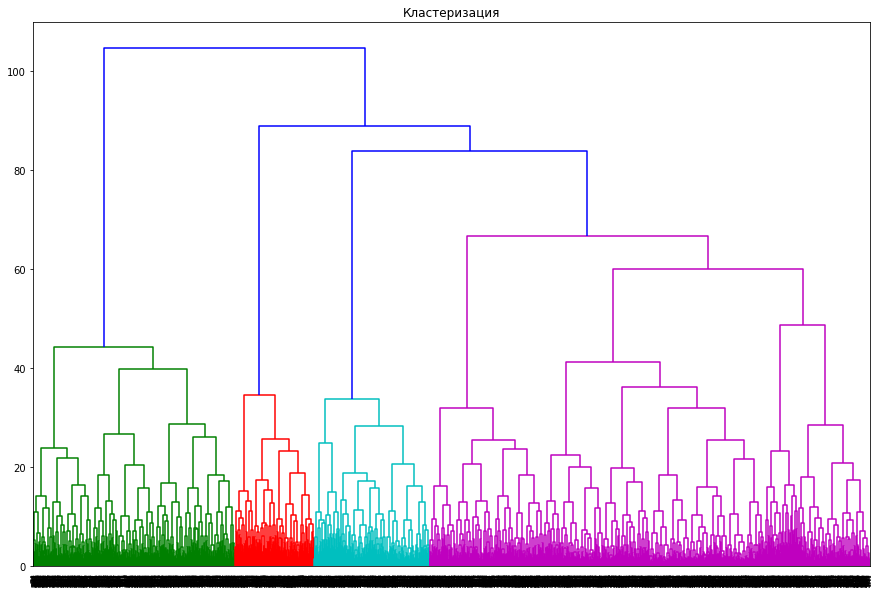

In [21]:
linked = linkage(x_sc, method = 'ward')
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Кластеризация')
plt.show()

На графике видим четыре разных цвета, то есть предложенное оптимальное число кластеров 4. Мы предположим, согласно условию задачи, что кластеров 5.

Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов. Зададим модель k_means с числом кластеров 5 и сформируем вектор кластеров, применив алгоритм к данным:

In [22]:
km = KMeans(n_clusters = 5, random_state=0)
labels = km.fit_predict(x_sc)
gym['cluster_km'] = labels

Количество клиентов в каждом кластере:

In [23]:
gym['cluster_km'].value_counts()

3    1262
0    1011
4     837
2     505
1     385
Name: cluster_km, dtype: int64

Количество клиентов в кластерах не только не одинаково, но и довольно сильно различается, порой даже в разы.

Выведем средние значения признаков для кластеров:

In [24]:
gym.groupby('cluster_km').mean().T

cluster_km,0,1,2,3,4
gender,0.50,0.52,0.50,0.49,0.56
near_location,0.96,0.86,0.00,1.00,0.98
partner,0.78,0.47,0.46,0.35,0.36
promo_friends,0.57,0.31,0.08,0.24,0.23
phone,1.00,0.00,1.00,1.00,1.00
contract_period,10.88,4.79,2.35,1.95,2.67
group_visits,0.54,0.43,0.22,0.34,0.47
age,29.98,29.30,28.48,28.17,30.13
avg_additional_charges_total,160.71,143.96,135.46,131.62,161.72
month_to_end_contract,9.95,4.48,2.20,1.86,2.46


- Наименьший отток показывают клиенты из кластера 0. Также у них видим самые длительные абонементы, они живут или работают поблизости от фитнес-центра, среди них примерно половина пришла по рекомендации (акция "Приведи друга"), они активней всех посещают групповые тренировки, тратят больше денег на дополнительные услуги клуба, у них довольно длинный лайфтайм, а частота посещения в неделю - 2;
- Ещё один надёжный кластер - 4. Клиенты из этого кластера в среднем старше всех остальных, также они недалеко от клуба живут/работают, тратят наибольшее количество денег на доп.услуги среди других кластеров, у них самый длительный лайфтайм, и они посещают тренировки в среднем около 3 раз в неделю;
- Большой отток показывает кластер 2. Этих клиентов характеризуют следующие признаки: они живут или работают далеко от фитнес-центра, лишь малая доля из них пришла по акции "Приведи друга", у них небольшая средняя продолжительность абонемента, они реже всех посещают групповые занятия, они в среднем моложе других, тратят меньшее количество денег в клубе, имеют довольно короткий лайфтайм, а частота их посещения в неделю меньше 2;
- Однако сильнее всего оттекают клиенты из кластера 3. Хотя эти клиенты живут или работают недалеко от фитнес-центра, их абоненменты имеют самый маленький срок действия. Из лайфтайм самый короткий из всех, а частота посещения в неделю - в среднем равна 1;
- Клиенты из кластеров 1 оттекают примерно с небольшой интенсивностью. В этом кластере наблюдается приличная длительность абонементов, и довольно продолжительный лайфтайм.

Построим распределения признаков для кластеров.

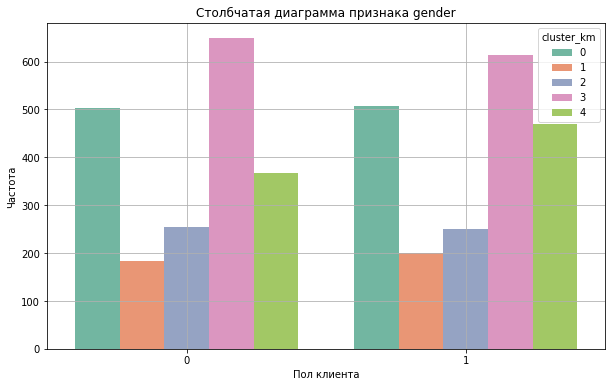

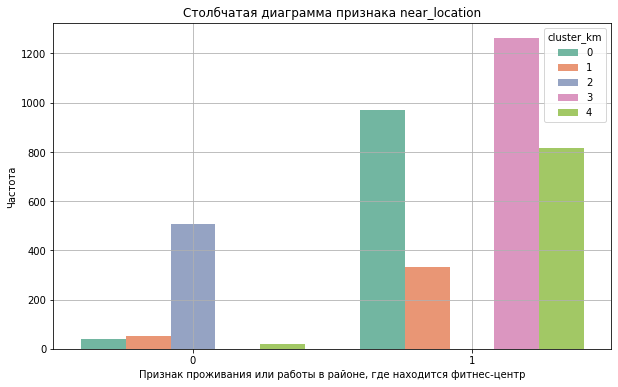

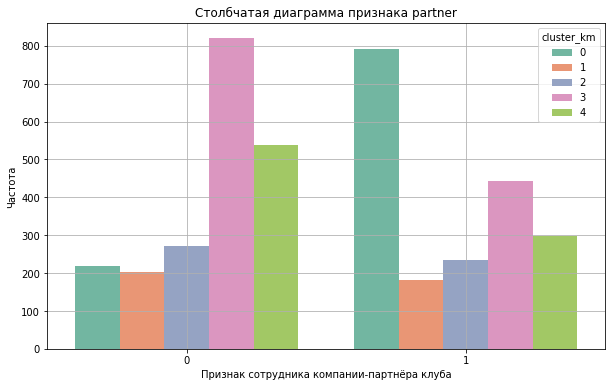

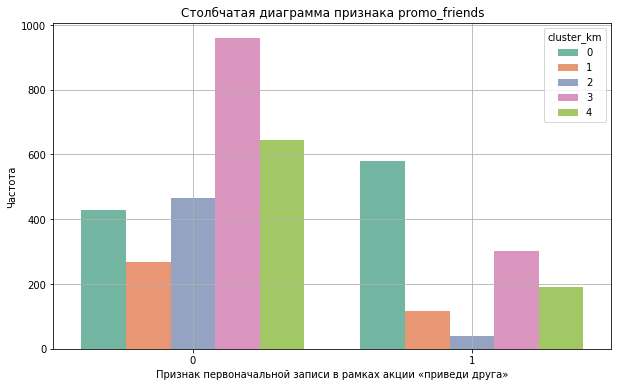

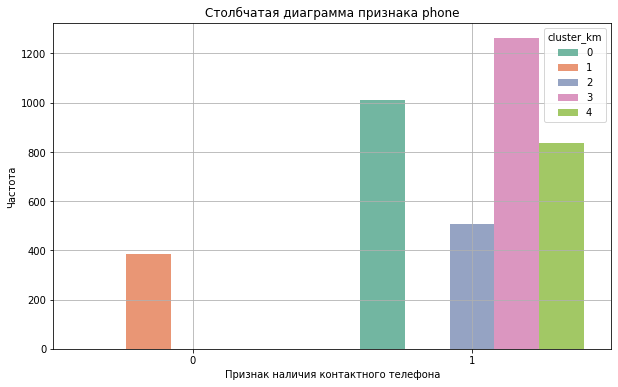

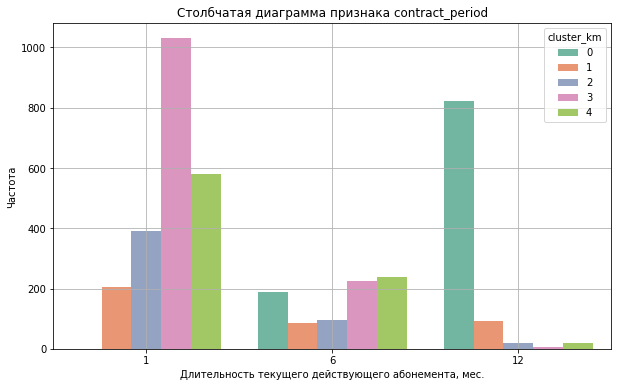

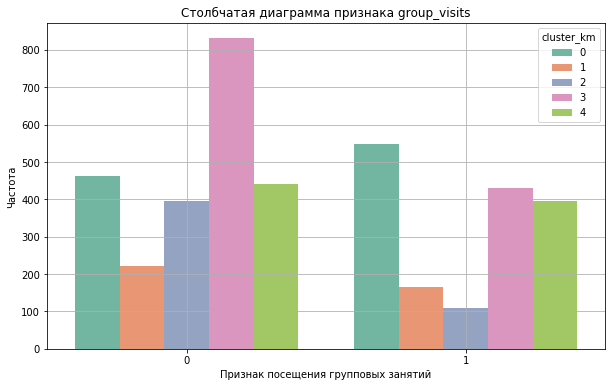

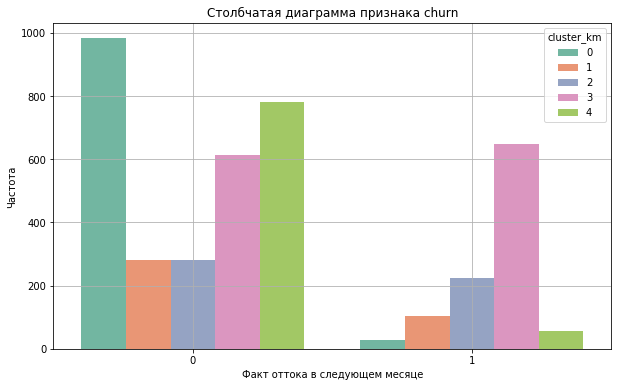

In [25]:
dict_of_features_bin = {'gender' : 'Пол клиента',
                        'near_location' : 'Признак проживания или работы в районе, где находится фитнес-центр', 
                        'partner' : 'Признак сотрудника компании-партнёра клуба',
                        'promo_friends' : 'Признак первоначальной записи в рамках акции «приведи друга»',
                        'phone': 'Признак наличия контактного телефона',
                        'contract_period': 'Длительность текущего действующего абонемента, мес.',
                        'group_visits': 'Признак посещения групповых занятий',
                        'churn': 'Факт оттока в следующем месяце'
                        }

for feature in dict_of_features_bin.keys():
    plt.figure(figsize=(10, 6))
    sns.countplot(x = gym[feature], hue='cluster_km', data=gym)
    plt.title('Столбчатая диаграмма признака ' + feature)
    plt.xlabel(dict_of_features_bin[feature])
    plt.ylabel('Частота')
    plt.grid()
    plt.show()

- Диаграмма по гендеру отражает лишь то, что в количество клиентов обоего пола в разных кластерах примерно одинаковое;
- Диаграмма по признаку проживания или работы невдалеке от фитнес-центра показывает, что клиентов с признаком `near_location = 1` в выборке больше. Также мы видим, что клиенты, живущие или работающие невблизи от фитнес-центра, почти полностью составляют кластер 2;
- По диаграмме признака сотрудника компании-партнёра видно, что больше всего клиентов-сотрудников таких компаний в кластерах 0 и 3. А меньше всего - в кластере 4;
- Диаграмма признака promo_friends указывает, что в кластере 2 собраны клиенты, не воспользовавшиеся акцией "Приведи друга";
- Диаграмму признака phone можно назвать, пожалуй, самой неинформативной. Не понятно, почему алгоритм поместил всех клиентов, не оставивших свой телефон, в кластер 1;
- Диаграмма длительности текущего абонемента отражает, что самые длительные абонементы имеют клиенты из кластера 0;
- Диаграмма по признаку посещения групповых занятий показывает, что клиенты из кластера 2 меньше посещают групповые тренировки;
- Диаграмма факта оттока иллюстрирует, что люди из 0-го и 4-го кластеров реже всех уходят.

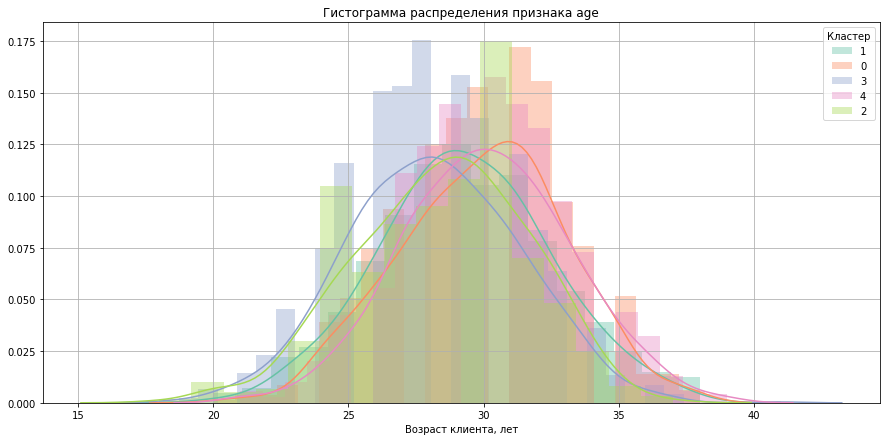

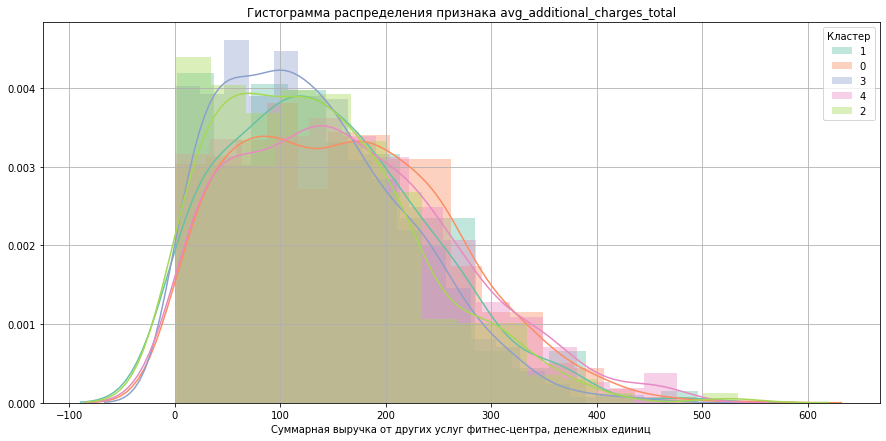

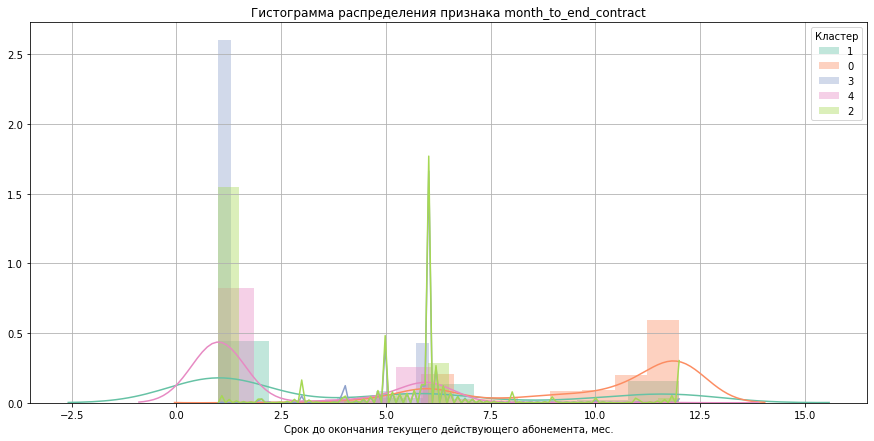

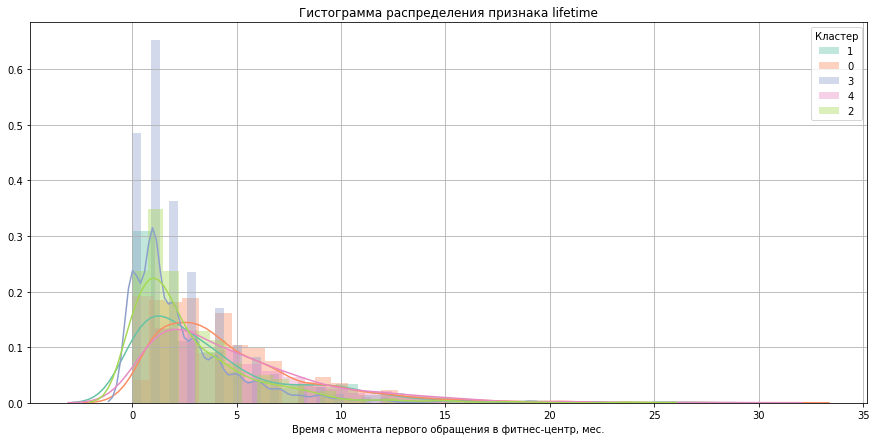

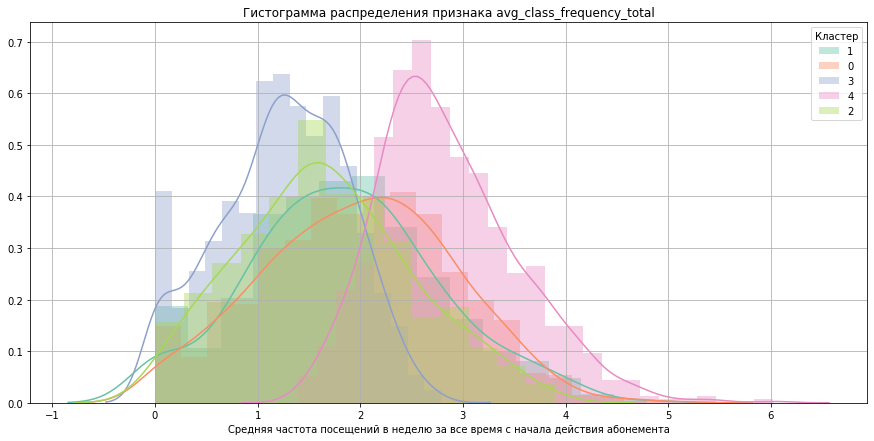

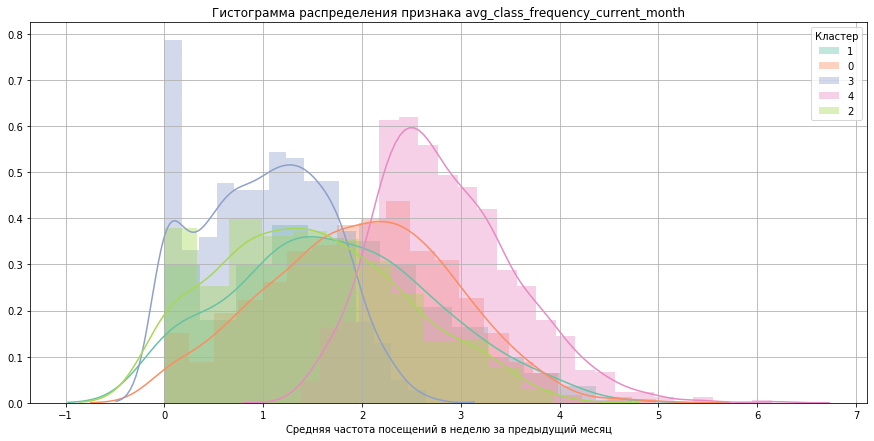

In [26]:
dict_of_features = {'age': 'Возраст клиента, лет',
                    'avg_additional_charges_total': 'Суммарная выручка от других услуг фитнес-центра, денежных единиц',
                    'month_to_end_contract': 'Срок до окончания текущего действующего абонемента, мес.',
                    'lifetime': 'Время с момента первого обращения в фитнес-центр, мес.',
                    'avg_class_frequency_total': 'Средняя частота посещений в неделю за все время с начала действия абонемента',
                    'avg_class_frequency_current_month': 'Средняя частота посещений в неделю за предыдущий месяц'
                   }

for feature in dict_of_features.keys():
    plt.figure(figsize=(15, 7))
    for i in gym['cluster_km'].unique().tolist():
        sns.distplot(gym[gym['cluster_km'] == i][feature], label=i)
        plt.legend(loc = 'upper right', title = 'Кластер')
    plt.title('Гистограмма распределения признака ' + feature)
    plt.xlabel(dict_of_features[feature])
    plt.grid()
    plt.show()

- Из графика распределения возраста видно, что пик значений кластера 0 приходится на число, большее 30, в то время как пик кластера 4 почти равен 30, однако пики значений остальных кластеров достигаются на отметках, меньших 30;
- Распределения суммарной выручки от других услуг фитнес-центра кластеров 0 и 4 заметно более пологие и растянутые, в то время как распределения остальных кластеров более остроконечные. Это говорит о том, что клиенты из 4-го кластера охотнее и больше тратят денег;
- Распределение времени с момента первого посещения наиболее пикообразно для кластеров 2 и 3. Самое пологое распределение - у кластеров 0 и 4, что означает, что клиенты оттуда имеют более длительный лайфтайм;
- Оба распределения средней частоты посещений в неделю очень похожи. В обеих случаях гистограммы кластеров 0 и 4 достигают своих пиков на больших значениях, чем все другие гистограммы.

Посчитаем долю оттока в каждом из кластеров:

In [27]:
(gym
    .groupby('cluster_km')
    .agg({'churn': 'mean', 'age': 'count'})
    .reset_index()
    .rename(columns={'cluster_km': 'Номер кластера', 'churn': 'Доля оттока', 'age': 'Число клиентов в кластере'})
)

,Номер кластера,Доля оттока,Число клиентов в кластере
0,0,0.03,1011
1,1,0.27,385
2,2,0.44,505
3,3,0.51,1262
4,4,0.07,837


Наиболее склонны к оттоку кластеры 2 и 3. Самые надёжные - кластеры 0 и 4. Кластер 1 имеет средний уровень оттока по сравнению с самыми надёжными и самыми ненадёжными кластерами.

**Вывод**

Стандартизировав данные, мы нарисовали дендрограмму, на основании которой выделили 5 кластеров. Алгоритмом K-Means мы обучили модель и сделали кластеризацию клиентов. В результате получили кластеры клиентов, наиболее склонных к оттоку, и кластеры более надёжных клиентов. Также мы выделили основные признаки, которые их характеризуют.

- Самые надёжные кластеры, где отток клиентов находится на минимальном уровне - это 0 и 4. У этих кластеров много общих признаков, таких, как близость фитнес-клуба к работе/дому, высокая доля людей, посещающих групповые занятия, средний возраст - 30 лет. Эти клиенты тратят больше других на доп.услуги клуба, у них самый продолжительный лайфтайм. Но есть и отличия: средняя длительность абонемента в кластере 0 равна 10.8 месяцам, а в кластере 4 - всего 2.7 месяцев. Еженедельная частота посещения спорт-клуба в кластере 0 составляет 2 раза/нед, а в кластере 4 - почти 3 раза/нед;
- Наиболее склонны к оттоку кластеры 2 и 3. У клиентов из этих кластеров также есть характерные признаки. Длительность их абонементов самая короткая, эти люди в среднем моложе клиентов из других кластеров, они тратят меньше всех денег в фитнес-центре, у них самые короткие лайфтаймы, а частота посещений в неделю не дотягивает до 2 раз. Из различий следует отметить, что клиенты из 2-го кластера живут/работают невблизи спорт-клуба, а клиенты из 3-го кластера - наоборот;
- Кластер 1 показывает невысокий процент оттока, однако он всё-таки довольно ощутим. У этих клиентов приличная продолжительность абонементов - в среднем почти 5 месяцев, хороший показатель лайфтайма. Другие показатели, такие как возраст, удаленность дома/работы от клуба, посещение групповых занятий, частота посещений в неделю, сумма трат находятся на промежуточном уровне между самыми надёжными и самыми ненадёжными в плане оттока кластерами. 

## Выводы и рекомендации

**Краткий вывод по проделанной работе**

Проведя исследовательский анализ данных, мы выяснили, что гендерный признак age и признак наличия контактного телефона phone не оказывают влияния на целевую переменную churn, а остальные признаки имеют с ней отрицательную корреляцию. Было обнаружено, что признаки `contract_period - month_to_end_contract` и `avg_class_frequency_total - avg_class_frequency_current_month` - мультиколлинеарны.

Построив модель бинарной классификации и обучив её двумя способами - логистической регрессии и случайным лесом - мы посчитали для каждого способа метрики accuracy, precision, recall. Сравнив их, мы пришли к выводу, что модель логистической регрессии показала себя лучше.

Сделав кластеризацию клиентов, мы получили 5 кластеров и выделили кластеры, склонные к оттоку (2 и 3), и надёжные кластеры (0 и 4). Кроме того, мы выделили основные признаки, которые характеризуют кластеры - о них подробно написано в выводе к пункту 5.
<br><br><br>
**Рекомендации для стратегии взаимодействия с клиентами**

* Так как реже всего оттекают клиенты с более длительным сроком абонемента, а чаще всего те, у кого абонементы на 1 месяц, то фитнес-центру следует пересмотреть систему абонементов в клубе. Можно минимальным сроком абонемента сделать 6 или даже 12 месяцев, но при этом обязательно сделать бесплатное пробное занятие;
* Как было выяснено, люди, посещающие групповые тренировки, попадают в отток с меньшей вероятностью. Поэтому следует привлекать клиентов на групповые занятия, ведь зачастую в группе с тренером человеку проще втянуться в тренировки;
* Реже уходят те, кто живёт или работает недалеко от фитнес-центра. Это значит, нужно рекламировать услуги клуба по локации, например, настроив в таргетированной рекламе показ объявлений на определенные районы города, близкие к клубу;
* Частота посещений в неделю также влияет на отток - чем реже человек ходит на спорт, тем проще ему бросить. Так что стоит стимулировать клиентов посещать занятия минимум 2 раза в неделю. Например, тренеры могут объяснять занимающимся, что для достижения результата необходимо заниматься с определённой частотой (не менее 2 раз в неделю).